In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Session 20b : torch FRCNN - Transfer Learning on Amimals Dataset
<img src='../../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com"/>

Faster R-CNN (FRCNN) is a deep learning model specifically designed for object detection tasks, meaning it identifies and classifies multiple objects within an image and draws bounding boxes around them. It builds on the original Region-Based Convolutional Neural Networks (R-CNN) and its predecessor Fast R-CNN, improving efficiency and accuracy. For this demo, we will be using PyTorch version of the Faster RCNN object detection model. They call it the Faster RCNN ResNet50 FPN V2.

### Architecture of Faster R-CNN
#### Convolutional Layers (Feature Extraction):

- This first stage uses a convolutional neural network (usually a backbone like ResNet, VGG, or Inception) to extract feature maps from the input image.
- These feature maps contain spatial information about the various objects and regions in the image.
#### Region Proposal Network (RPN):

- The RPN generates potential regions or object proposals. It’s a lightweight neural network that proposes regions likely to contain objects.
- It outputs two results:
    - Objectness scores: Probabilities that a region contains an object or background.
    - Bounding box coordinates: Predictions for bounding box locations.
- The RPN slides over the feature map, examining each location to predict regions likely to contain objects. Non-Maximum Suppression (NMS) is then applied to eliminate redundant proposals.
#### ROI Pooling:

- Faster R-CNN uses a technique called ROI (Region of Interest) Pooling, which extracts fixed-size feature maps from proposals.
- ROI Pooling applies spatial transformation to maintain a consistent feature map size for each region, making them compatible with the next stage.
#### Fully Connected Layers (Classification and Bounding Box Regression):

- Each fixed-size feature map from ROI Pooling is passed to fully connected layers to classify the objects and refine the bounding box coordinates further.
#### Output:

The final output includes bounding box coordinates, classes, and a class label for each detected object in the image.

<img src = '../../../images/faster_R_CNN.png'>

[Figure 2: Faster R-CNN is a single, unified network for object detection.](https://arxiv.org/pdf/1506.01497)

The RPN module serves as the 'attention' of this unified network.


In [2]:
### Import Libraries
import os
import time
import gc
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision.utils import draw_bounding_boxes
from PIL import Image

import cv2

from tqdm import trange, tqdm

#from utils.helper import fn_plot_confusion_matrix, fn_plot_tf_hist

In [3]:
# Some basic parameters

inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'Animals' # location of the images
modelDir = '../models'
altName = 'ani_rcnn'



RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
BATCH_SIZE = 4
EPOCHS = 2
THRESHOLD = 0.3 # 0.5
TRAIN = True # Do you want to train or predict
ALPHA = 0.001
REG_LAMDA = 0.01
# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,12),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## All about CUDA

In [4]:
print ('Is CUDA available: ', torch.cuda.is_available())
print ('CUDA version: ', torch.version.cuda )
print ('Current Device ID: ', torch.cuda.current_device())
print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Is CUDA available:  True
CUDA version:  12.4
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU
Using cuda device


## Helper Functions
### Load Image

In [5]:
# Load the input image and apply transformations
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    
    # Create a BGR copy of the image for annotation.
    image_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    return image, image_bgr

In [6]:
def draw_boxes(boxes, classes, labels, image):
    '''`
    Draws bounding boxes with labels on an image to represent detected objects.

    Args:
        boxes (list): A list of bounding box coordinates for each detected object,
                    where each box is represented by [x_min, y_min, x_max, y_max].
        classes (list): A list of class names corresponding to each bounding box.
        labels (list): A list of label indices for each detected object; these are 
                    used to pick specific colors for each class.
        image (numpy array): The image on which to draw the bounding boxes.

    Returns:
        image (numpy array): The modified image with bounding boxes and labels drawn on it.
    '''

    # Determine line width for the bounding boxes based on image dimensions.
    # This sets the line width to a fraction of the sum of image height and width,
    # with a minimum width of 2 to ensure visibility.
    lw = max(round(sum(image.shape) / 2 * 0.005), 2)

    # Determine font thickness, set to one less than line width but with a minimum of 2.
    tf = max(lw - 1, 2)

    # Loop through each bounding box to draw it on the image.
    for i, box in enumerate(boxes):
        # Select a color for the bounding box from the COLORS array, using the label index.
        # COLORS is a predefined array where each index corresponds to a specific color.
        color = COLORS[labels[i]]

        # Draw the bounding box as a rectangle on the image.
        
        cv2.rectangle(
            img=image,
            pt1=(int(box[0]), int(box[1])), # top-left corner of the box.
            pt2=(int(box[2]), int(box[3])), # bottom-right corner of the box.
            color= color[::-1],              # Reversed to BGR for OpenCV
            thickness=lw                    # set to lw to maintain consistency with text.
        )

        # Add text to label the bounding box with the class name.        
        cv2.putText(
            img=image, 
            text=classes[i], 
            org=(int(box[0]), int(box[1] - 5)),  # 5 pixels above the top-left corner
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw / 2,                    # proportional to line width for a balanced appearance.
            color= color[::-1],                   # Reversed to BGR for OpenCV
            thickness=tf,                        # set to tf for good legibility.
            lineType=cv2.LINE_AA                 # anti-aliased text for smoothness.
        )

    # Return the modified image with all bounding boxes and labels.
    return image

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

#### The Animal Dataset Category Names

In [8]:
animal_category_names = os.listdir(os.path.join(inpDir, subDir, 'train'))
animal_category_names.append('__background__')
animal_category_names.sort()
# display(animal_category_names)
 
# Create different colors for each class.
COLORS = np.random.uniform(0, 255, size=(len(animal_category_names), 3))
# Define the torchvision image transforms.

def get_transform(train):
    transforms = []

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5)) # used for training only
    
    # transforms.append(T.Resize((224, 224))),  # Resize image to 224x224 (or any size you need)
    # transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], 
    #                               std=[0.229, 0.224, 0.225]))  # Example normalization
    transforms.append(T.ToDtype(torch.float, scale=True))
    
    transforms.append(T.ToPureTensor())
    
    return T.Compose(transforms)

In [9]:
class AnimalDataset(torch.utils.data.Dataset):
    # List of supported image file extensions
    img_extn = ['.jpg', '.png', '.jpeg'] # allowable images
    # img_extn = {".png", ".jpg", ".jpeg", ".bmp", ".gif", ".tiff"}

    def __init__(self, root, transforms):
        self.root = root
        self.catagory_names= list(sorted(os.listdir(root)))
        self.transforms = transforms

        # load all image files, sorting them to ensure that they are aligned
        self.imgs = []
        self.label_names = []
        for cat in self.catagory_names:
            directory = os.path.join(root, cat)
            self.imgs +=list(sorted([os.path.join(directory, file)  # append complete path
                                for file in os.listdir(directory) # get the file name
                                if os.path.isfile(os.path.join(directory, file)) #is it a file
                                and file.lower().endswith(tuple(self.img_extn))])) # is it an image
            
            lbl_dir = os.path.join(root, cat, 'Label')        
            self.label_names += list(sorted([os.path.join(lbl_dir, file)
                                        for file in os.listdir(lbl_dir)
                                        if os.path.isfile(os.path.join(lbl_dir, file))
                                        ]))
        

    def __getitem__(self, idx):
        # load images and masks
        img = read_image(self.imgs[idx])
        
        with open(self.label_names[idx], 'r') as file:
            for line in file:

                values = line.strip().split()  # Split the line into values
                label = ' '.join( values[0:-4])              # Extract the first value as the label    

                box = np.array(values[-4:], dtype=np.float64)  # Convert remaining values to a NumPy array
                
        label_id = self.catagory_names.index(label)
        image_id = idx

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(box, format="XYXY", canvas_size=F.get_size(img))
        target["label"] = [label]
        target["image_id"] = [image_id]
        target["label_id"] = torch.tensor([label_id], dtype=torch.int64)
    
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [10]:
train_ds = AnimalDataset(os.path.join(inpDir,subDir, 'train'), get_transform(train=True))
train_ds.imgs[0],train_ds.label_names[0]

('../../../input/Animals/train/Bear/0155b267ade95d1e.jpg',
 '../../../input/Animals/train/Bear/Label/0155b267ade95d1e.txt')

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn # without this function, it will complain that images are of different shapes
)

In [12]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
len(images), len(targets)

(4, 4)

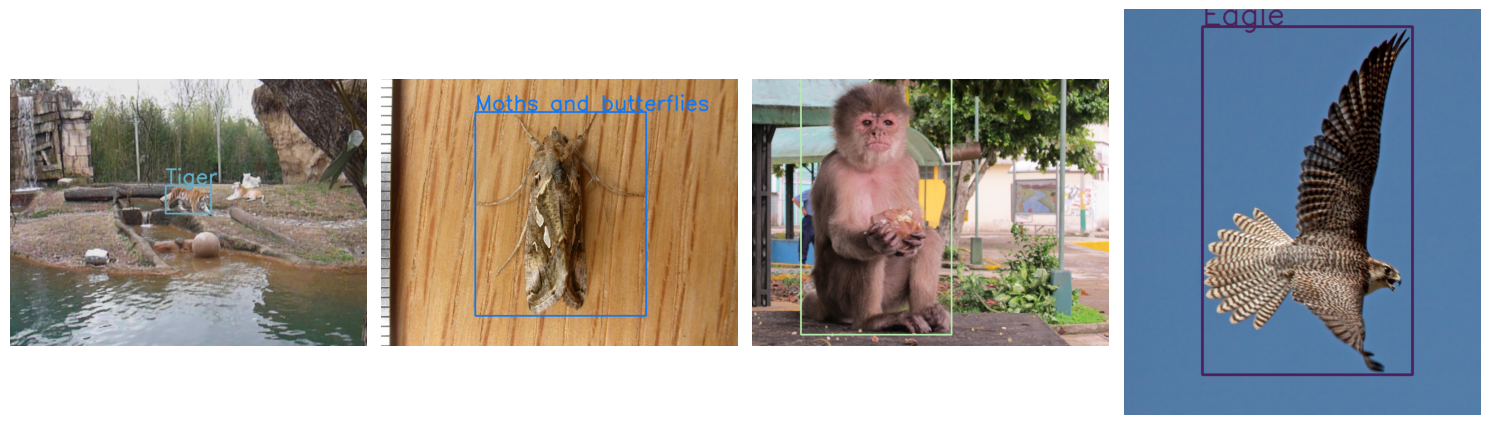

In [13]:
fig,axes = plt.subplots(1, BATCH_SIZE, figsize = (15,12))
axes = axes.ravel()

for i, ax in enumerate(axes):
    img = (255.0 * (images[i] - images[i].min()) / (images[i].max() - images[i] .min())).to(torch.uint8)
    img = img.permute(1, 2, 0).numpy()
    boxes = targets[i]['boxes'].long().numpy()
    labels = targets[i]['label']
    label_id = targets[i]['label_id']
    output_image = draw_boxes(boxes, labels, label_id, img)
    ax.imshow(output_image)
    ax.axis('off')

plt.tight_layout();

In [14]:
# Load a pre-trained Faster R-CNN model
def get_model(mPath, device='cuda'):
     
    # Load the model.
    if os.path.exists(mPath):
        print (f'Found a model at {mPath}')
        # Load Model
        model = torch.load(mPath, weights_only=False)

    else:
        print(f'No model at {mPath}')
        # Load pre-trained Faster R-CNN
        # FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT is equivalent to 
        # FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1. You can also use strings, 
        # e.g. weights='DEFAULT' or weights='COCO_V1'.
        model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')

        # Freeze all layers except the box_predictor
        for param in model.backbone.parameters():
            param.requires_grad = False

        # Unfreeze the parameters of the box_predictor
        for param in model.roi_heads.box_predictor.parameters():
            param.requires_grad = True
        
        # Modify the classifier head to match the number of classes in your dataset
        num_classes = len(animal_category_names)  # Example: num classes + 1 background
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model.to(device)

In [15]:
modelPath  = os.path.join(modelDir, subDir,f'{altName}_adam.pth')
model = get_model(modelPath, device)

Found a model at ../models/Animals/ani_rcnn_adam.pth


In [16]:
if TRAIN:
    # Optimizer
  # optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
  optimizer = optim.AdamW(model.roi_heads.box_predictor.parameters(), lr=ALPHA, weight_decay=REG_LAMDA)
  # Learning rate scheduler
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

  # Training loop
  best_loss = np.inf

  for epoch in range(EPOCHS):
      model.train()
      epoch_loss = 0
      
      for images, targets in tqdm(train_loader):
          # convert RGBA -> RGB and move to device
          images = [img[:3, ...].to(device) for img in images]
          
          tgts = []
          for t in targets:
              tgts.append({'boxes': targets[0]['boxes'].to(device), 
                          'labels':targets[0]['label_id'].to(device)})
          #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          # Forward pass
          loss_dict = model(images, tgts)
          losses = sum(loss for loss in loss_dict.values())

          # Backward pass
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          epoch_loss += losses.item()

      # Update learning rate
      lr_scheduler.step()

      if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model, modelPath)
        
      print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")


100%|██████████| 5642/5642 [1:15:17<00:00,  1.25it/s]


Epoch 1, Loss: 1730.4560097210644


100%|██████████| 5642/5642 [1:15:13<00:00,  1.25it/s]


Epoch 2, Loss: 1724.122429983458


- Epoch 1, Loss: 1775.1762801424761
- Epoch 2, Loss: 1817.2913126487679
- Epoch 3, Loss: 1803.7365140364727
- Epoch 1, Loss: 1731.6209088691999
- Epoch 2, Loss: 1725.2527298865916
- Epoch 1, Loss: 1784.236123213113
- Epoch 1, Loss: 1730.4560097210644

### Load Test data

5849

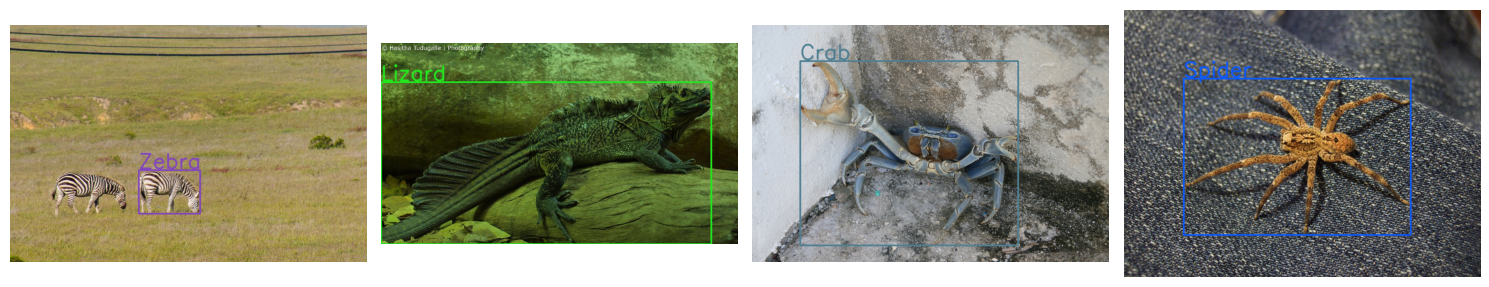

In [18]:
test_ds = AnimalDataset(os.path.join(inpDir,subDir, 'test'), get_transform(train=False))
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn # without this function, it will complain that images are of different shapes
)
images, targets = next(iter(test_loader))
plot_imgs = list(image for image in images)
plot_tgts = [{k: v for k, v in t.items()} for t in targets]
'''
    In plot:
        'boxes': tensor([[ 79.2556,   8.8205, 901.8358, 739.9127]], dtype=torch.float64),
        'label': ['Fish'],
        'image_id': [1577],
        'label_id': tensor([17])
'''
fig,axes = plt.subplots(1, BATCH_SIZE, figsize = (15,12))
axes = axes.ravel()

for i, ax in enumerate(axes):
    img = (255.0 * (plot_imgs[i] - plot_imgs[i].min()) / (plot_imgs[i].max() - plot_imgs[i] .min())).to(torch.uint8)
    img = img.permute(1, 2, 0).numpy()
    boxes = plot_tgts[i]['boxes'].long().numpy()
    labels = plot_tgts[i]['label']
    label_id = plot_tgts[i]['label_id']
    output_image = draw_boxes(boxes, labels, label_id, img)
    ax.imshow(output_image)
    ax.axis('off')

plt.tight_layout();

del plot_imgs, plot_tgts
gc.collect()

##### Predict Function

In [19]:
def predict(image, model, device, detection_threshold = 0.5, animal_names=animal_category_names):
    """
    Predict the output of an image after forward pass through
    the model and return the bounding boxes, class names, and 
    class labels. 
    """
    #get the transformer
    transform = get_transform(False)
    # Transform the image to tensor.
    image = transform(image).to(device)
    # Add a batch dimension.
    image = image.unsqueeze(0) 
    # Get the predictions on the image.
    with torch.no_grad():
        outputs = model(image) 
    # Get score for all the predicted objects.
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # Get all the predicted bounding boxes.
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # Get boxes above the threshold score.
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    labels = outputs[0]['labels'][:len(boxes)]

    # pick scores of selecgted boxes
    pred_scores = pred_scores[:len(boxes)]
    # Get all the predicted class names.
    pred_classes = [animal_names[i] for i in labels.cpu().numpy()]
    return boxes, pred_classes, labels, pred_scores

  1%|          | 9/1627 [00:05<17:04,  1.58it/s]


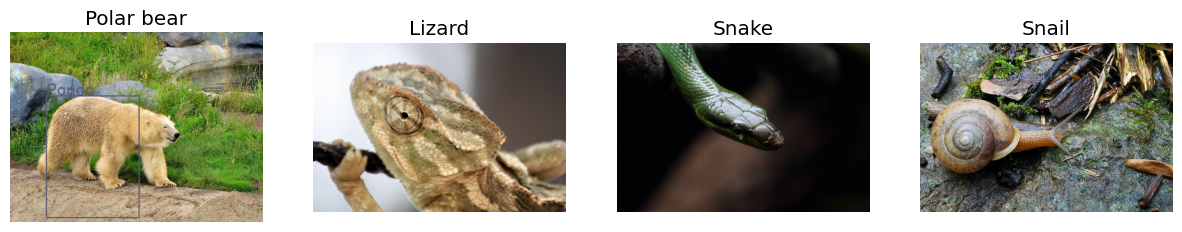

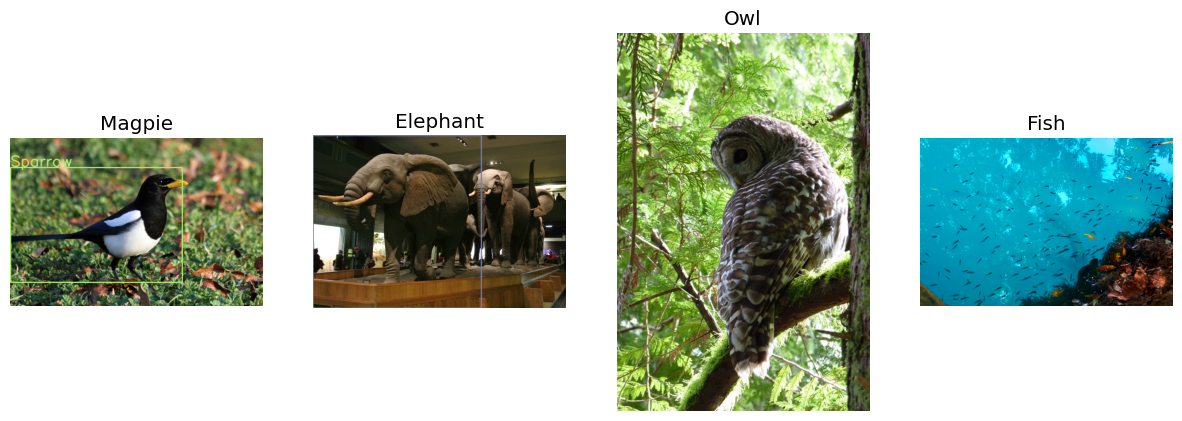

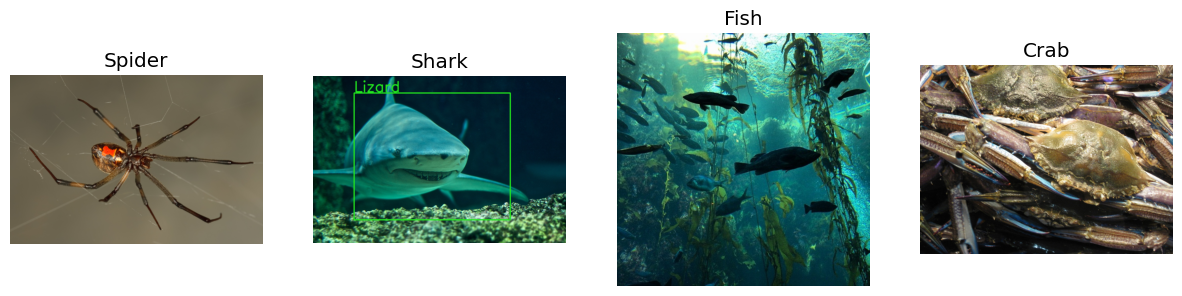

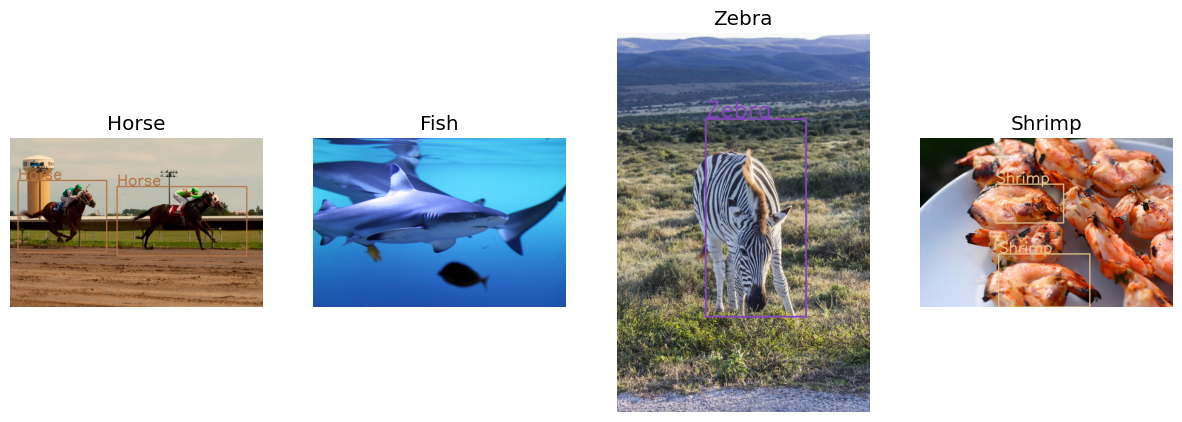

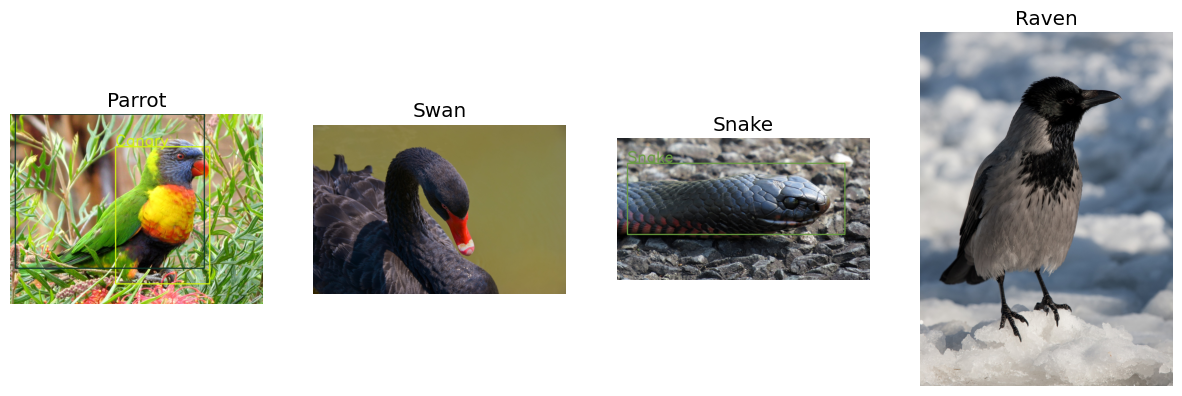

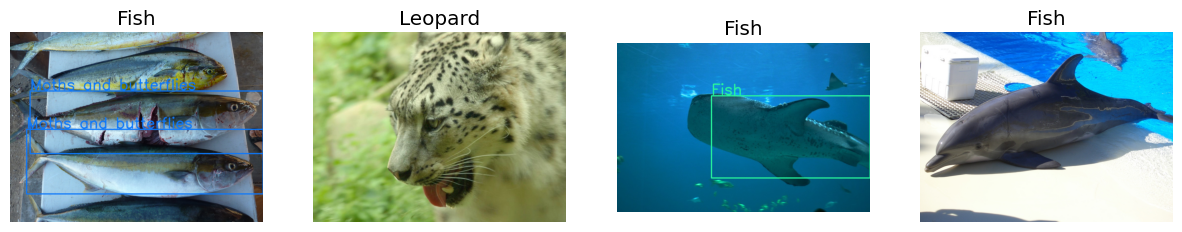

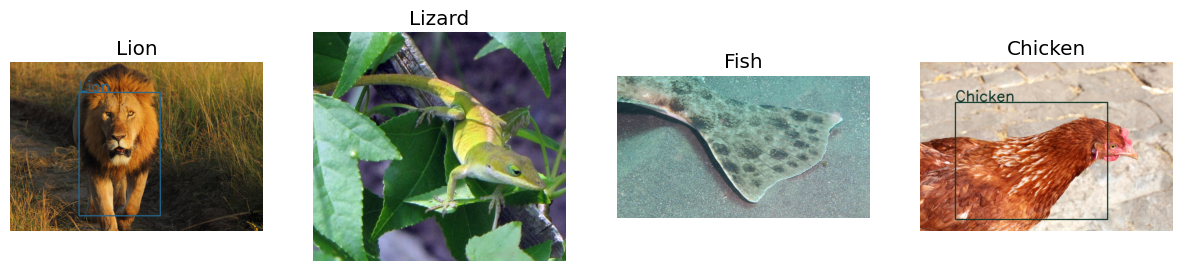

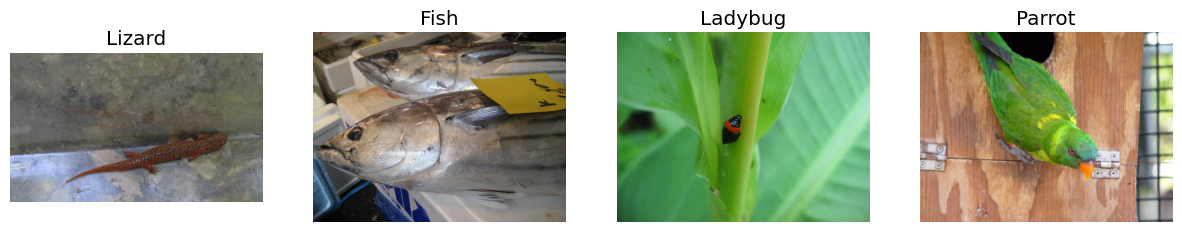

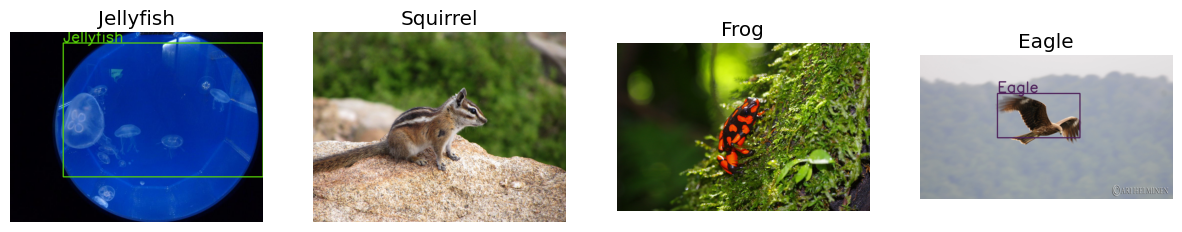

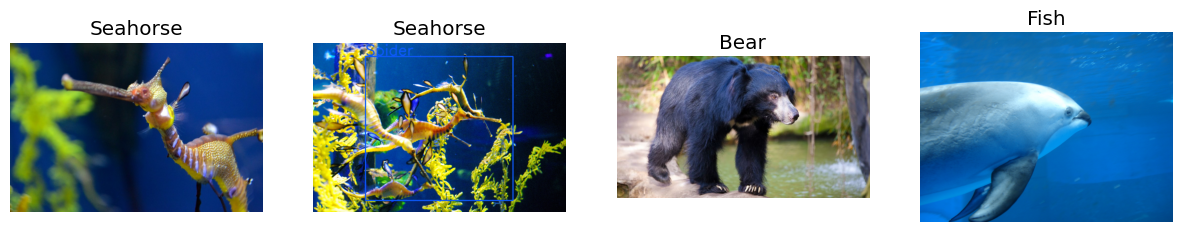

In [20]:
model.eval() # Set model in eval mode
count = 0
for images, targets in tqdm(test_loader):
    # convert RGBA -> RGB and move to device
    images = [img[:3, ...].to(device) for img in images]
    plot_imgs = list(image for image in images)

    fig, axes = plt.subplots(1, BATCH_SIZE, figsize = (15,12))
    axes = axes.ravel()

    tgts = []
    for t in targets:
        tgts.append(animal_category_names[t['label_id'].cpu().item()])
        # tgts.append({'boxes': targets[0]['boxes'].to(device), 
        #                 'labels':targets[0]['label_id'].to(device)})
        # #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

        '''
        In output: 
            'boxes': tensor([[212.2369, 114.3758, 765.8919, 569.3187],
                             [234.3809,  57.3905, 692.2795, 521.9914],
                             [181.5516, 112.4048, 810.5187, 580.8567]], device='cuda:0'),
            'labels': tensor([40,  3, 36], device='cuda:0'),
            'scores': tensor([0.0619, 0.0523, 0.0511], device='cuda:0')}
        '''
    for i, output in enumerate(outputs):    
        # Get score for all the predicted objects.
        pred_scores = output['scores'].detach().cpu().numpy()
        # Get all the predicted bounding boxes.
        pred_bboxes = output['boxes'].detach().cpu().numpy()
        # Get boxes above the threshold score.
        boxes = pred_bboxes[pred_scores >= THRESHOLD].astype(np.int32)
        label_ids = output['labels'][:len(boxes)].cpu().numpy()
        # Get all the predicted class names.
        pred_classes = [animal_category_names[label_id] for label_id in label_ids]
        
    
        ax = axes[i]
        img = (255.0 * (plot_imgs[i] - plot_imgs[i].min()) / (plot_imgs[i].max() - plot_imgs[i] .min())).to(torch.uint8)
        img = img.permute(1, 2, 0).cpu().numpy()
        ax.set_title(tgts[i]) # add original label as title
        if len(pred_classes)>0:
            output_image = draw_boxes(boxes, pred_classes, label_ids, img)
        else:
            output_image = img
            #print(f'image {i}: No class detected')
            ax.set_xlabel('No class detected')
        ax.imshow(img) #output_image
        
        ax.axis('off')
    count += 1
    if count >=10:
         break

In [ ]:
tgts

In [21]:
imgName = 'ce92d553.png' # 'IMG_1295.JPG'
# Load an example image
image_path = os.path.join(outDir, subDir, imgName)  # specify your image path
image = read_image(image_path)

In [ ]:
img_tv = tv_tensors.Image(image)
image = image.permute(1, 2, 0).cpu().numpy()
image.shape

In [ ]:
# Detect outputs.
with torch.no_grad():
    boxes, classes, labels, scores = predict(img_tv, model, device, detection_threshold= THRESHOLD)
    
boxes, classes, labels, scores

In [24]:

# Draw bounding boxes.
image = draw_boxes(boxes, classes, labels, image)


In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()
ax.imshow(image)